# EG24 CITE-seq and flow cytometry comparisons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
from ridgeplot import ridgeplot

import sklearn.mixture

import warnings

warnings.filterwarnings('ignore')

Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


### Sample information:
- ALL
- relapse
- 80% of bone marrow cells are blasts


## Preparing files

In [2]:
#raw protein data, all datasets, raw + CLR and DSB normalized

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_easi_norm.h5ad')

adata.shape

(121340, 8051)

In [3]:
#select sample
adata_sample=adata[adata.obs['eg_code'] == 'EG24']

In [4]:
#selecting only leukemic cells

eg_blasts=adata_sample[adata_sample.obs['new_cell_type'] == 'leukemic']

eg_blasts.obs['new_cell_type']

AAACGGGTCTACTTAC-1-119    leukemic
AAAGATGAGGAGTAGA-1-119    leukemic
AAAGCAACACAGACTT-1-119    leukemic
AAAGCAACAGGGTATG-1-119    leukemic
AAAGCAACATCACAAC-1-119    leukemic
                            ...   
TTTGCGCAGCCAACAG-1-119    leukemic
TTTGGTTAGAGCTGCA-1-119    leukemic
TTTGTCAAGGTTCCTA-1-119    leukemic
TTTGTCAGTATCACCA-1-119    leukemic
TTTGTCATCAATCACG-1-119    leukemic
Name: new_cell_type, Length: 1011, dtype: category
Categories (1, object): ['leukemic']

In [5]:
#select CLR normalized protein counts (only leukemic cells)

prot_clr=eg_blasts.obsm['protein_expression_clr']

prot_clr

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACGGGTCTACTTAC-1-119,1.736651,3.117820,1.405150,0.796443,0.796443,0.931404,1.873557,1.270729,0.606020,0.000000,...,0.325352,0.673604,1.050297,0.228207,0.673604,1.725300,0.606020,0.413889,0.277958,0.767119
AAAGATGAGGAGTAGA-1-119,0.996005,3.812860,1.220955,0.450533,0.205109,0.647437,0.996005,0.760010,0.375225,0.000000,...,0.450533,0.450533,0.520565,0.293780,1.186804,2.086596,0.705307,0.450533,0.205109,0.953053
AAAGCAACACAGACTT-1-119,1.197050,3.369727,1.521922,0.297546,0.592563,0.526562,1.231351,0.712779,0.379852,0.109318,...,0.455895,0.526562,0.820082,0.207854,1.161531,2.280266,0.592563,0.379852,0.000000,0.962119
AAAGCAACAGGGTATG-1-119,1.322475,3.996407,0.364943,0.199028,0.631731,0.688622,1.054951,1.092575,0.507207,0.199028,...,0.199028,0.842125,0.364943,0.285422,1.292695,1.820520,0.793529,0.631731,0.199028,0.932758
AAAGCAACATCACAAC-1-119,1.484887,4.283628,1.032351,0.337687,0.471598,0.589676,1.507382,0.643868,0.337687,0.337687,...,0.406883,0.532379,0.589676,0.263346,0.532379,1.875396,0.877948,0.643868,0.337687,1.389481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCAGCCAACAG-1-119,0.886533,4.360054,0.437436,0.791729,0.437436,1.090390,2.161279,0.505900,0.284606,0.104131,...,0.284606,0.363938,0.437436,0.505900,0.630192,2.222564,0.437436,0.840254,0.000000,1.663946
TTTGGTTAGAGCTGCA-1-119,1.128562,3.500698,0.841896,0.631542,0.742240,0.438460,1.128562,1.054689,0.571231,0.198955,...,0.631542,0.571231,0.841896,0.198955,0.688422,2.201066,0.841896,0.198955,0.198955,0.438460
TTTGTCAAGGTTCCTA-1-119,1.019816,3.765607,0.482698,1.642062,0.634640,0.535952,1.432900,0.724457,0.535952,0.303460,...,0.482698,0.426447,0.535952,0.426447,0.766512,2.022730,0.919000,1.111393,0.084924,1.195282
TTTGTCAGTATCACCA-1-119,1.461947,3.748793,1.694896,1.404094,0.395433,0.636162,1.384042,0.636162,0.339460,0.339460,...,0.339460,0.678061,0.217136,0.280167,0.961936,2.142172,0.678061,0.678061,0.077737,1.461947


In [6]:
#select DSB normalized protein counts

prot_dsb=eg_blasts.obsm['protein_expression_dsb']

prot_dsb

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACGGGTCTACTTAC-1-119,5.235474,6.765774,3.392691,0.808834,3.707282,2.972158,9.732417,12.509436,2.973591,-1.510255,...,0.891578,1.754948,2.642372,0.046999,5.641718,6.519819,1.705478,1.870252,2.644428,2.188816
AAAGATGAGGAGTAGA-1-119,1.098276,7.259014,1.393066,-0.646733,-1.678327,-0.076621,1.911605,4.575176,-0.277374,-1.510255,...,0.454759,-1.025544,-0.143150,-0.384310,7.088585,5.934313,0.767981,0.640264,0.505158,1.311661
AAAGCAACACAGACTT-1-119,1.726878,5.649791,2.285491,-0.962689,0.447542,-0.641244,3.161980,4.131022,-0.277374,-0.705994,...,0.454759,-0.674252,0.707019,-0.850160,6.819550,6.734242,0.222203,0.174821,-1.242754,1.311661
AAAGCAACAGGGTATG-1-119,2.258353,8.020568,-1.144322,-1.139418,0.796405,0.182565,2.358955,7.488725,0.597070,0.028237,...,-1.055551,1.059134,-0.560621,-0.384310,8.081855,4.882566,1.259085,1.870252,0.505158,1.311661
AAAGCAACATCACAAC-1-119,3.047345,9.353902,1.068179,-0.799064,0.077523,-0.076621,5.328226,4.131022,-0.277374,1.329014,...,0.454759,-0.344264,0.225084,-0.384310,2.581179,5.473848,1.914316,2.235003,1.982996,4.218381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCAGCCAACAG-1-119,0.810795,9.314544,-0.924099,0.096173,-0.316384,2.041421,8.672638,2.642952,-0.762677,-0.705994,...,-0.513795,-1.401081,-0.344923,0.824153,3.034776,6.681586,-0.391966,3.224028,-1.242754,5.373164
TTTGGTTAGAGCTGCA-1-119,1.609993,6.275143,0.298399,-0.244180,1.439466,-0.950627,2.774324,7.173814,0.994076,0.028237,...,1.688773,-0.344264,0.852458,-0.850160,3.463843,6.574390,1.487356,-0.865119,0.505158,-1.362772
TTTGTCAAGGTTCCTA-1-119,1.726878,7.955753,-0.524583,2.300853,1.439466,-0.076621,5.455982,5.400477,1.368383,1.329014,...,1.301905,-0.674252,0.225084,0.824153,4.980019,6.628307,2.492271,5.959399,-0.329018,3.618855
TTTGTCAGTATCACCA-1-119,3.556360,8.214930,3.756397,1.921420,0.077523,0.662341,5.580991,4.997655,0.174433,1.911199,...,0.454759,1.059134,-0.792311,0.046999,7.088585,7.546330,1.487356,3.224028,-0.329018,5.600803


In [7]:
#convert excel to csv (flow data)

read_file = pd.read_excel (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.xlsx')
read_file.to_csv (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv', index = None, header=True)

In [8]:
#get flow data

flow= pd.read_csv('/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv')

### Depending on used dataset, celltype annotations are varying (made by different groups). "new_cell_types" is made based on these, it is a "standardized" version of cell type annotations. 

In [9]:
#Cell types offered by new_cell_type

adata.obs['new_cell_type'].unique().tolist()

['NK',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

In [10]:
#cell type annotations offered by cell_type

adata.obs['cell_type'].unique().tolist()

['NKT',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

## CLR normalized



In [11]:
#CLR normalized, only leukemic cells

prot_clr

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACGGGTCTACTTAC-1-119,1.736651,3.117820,1.405150,0.796443,0.796443,0.931404,1.873557,1.270729,0.606020,0.000000,...,0.325352,0.673604,1.050297,0.228207,0.673604,1.725300,0.606020,0.413889,0.277958,0.767119
AAAGATGAGGAGTAGA-1-119,0.996005,3.812860,1.220955,0.450533,0.205109,0.647437,0.996005,0.760010,0.375225,0.000000,...,0.450533,0.450533,0.520565,0.293780,1.186804,2.086596,0.705307,0.450533,0.205109,0.953053
AAAGCAACACAGACTT-1-119,1.197050,3.369727,1.521922,0.297546,0.592563,0.526562,1.231351,0.712779,0.379852,0.109318,...,0.455895,0.526562,0.820082,0.207854,1.161531,2.280266,0.592563,0.379852,0.000000,0.962119
AAAGCAACAGGGTATG-1-119,1.322475,3.996407,0.364943,0.199028,0.631731,0.688622,1.054951,1.092575,0.507207,0.199028,...,0.199028,0.842125,0.364943,0.285422,1.292695,1.820520,0.793529,0.631731,0.199028,0.932758
AAAGCAACATCACAAC-1-119,1.484887,4.283628,1.032351,0.337687,0.471598,0.589676,1.507382,0.643868,0.337687,0.337687,...,0.406883,0.532379,0.589676,0.263346,0.532379,1.875396,0.877948,0.643868,0.337687,1.389481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCAGCCAACAG-1-119,0.886533,4.360054,0.437436,0.791729,0.437436,1.090390,2.161279,0.505900,0.284606,0.104131,...,0.284606,0.363938,0.437436,0.505900,0.630192,2.222564,0.437436,0.840254,0.000000,1.663946
TTTGGTTAGAGCTGCA-1-119,1.128562,3.500698,0.841896,0.631542,0.742240,0.438460,1.128562,1.054689,0.571231,0.198955,...,0.631542,0.571231,0.841896,0.198955,0.688422,2.201066,0.841896,0.198955,0.198955,0.438460
TTTGTCAAGGTTCCTA-1-119,1.019816,3.765607,0.482698,1.642062,0.634640,0.535952,1.432900,0.724457,0.535952,0.303460,...,0.482698,0.426447,0.535952,0.426447,0.766512,2.022730,0.919000,1.111393,0.084924,1.195282
TTTGTCAGTATCACCA-1-119,1.461947,3.748793,1.694896,1.404094,0.395433,0.636162,1.384042,0.636162,0.339460,0.339460,...,0.339460,0.678061,0.217136,0.280167,0.961936,2.142172,0.678061,0.678061,0.077737,1.461947


In [12]:
#flow results for selected sample

egflow=flow[flow['EG_code'] == 'EG24'].dropna(axis=1)

egflow

,EG_code,CD10,CD19,CD22,CD34,CD38,CD58,CD66c,CD133,HLA-DR
1,EG24,1.0,1.0,1.0,0.68,1.0,1.0,0.45,0.51,1.0


In [13]:
#drop EG_code

egflow=egflow.drop("EG_code", axis=1)

egflow

,CD10,CD19,CD22,CD34,CD38,CD58,CD66c,CD133,HLA-DR
1,1.0,1.0,1.0,0.68,1.0,1.0,0.45,0.51,1.0


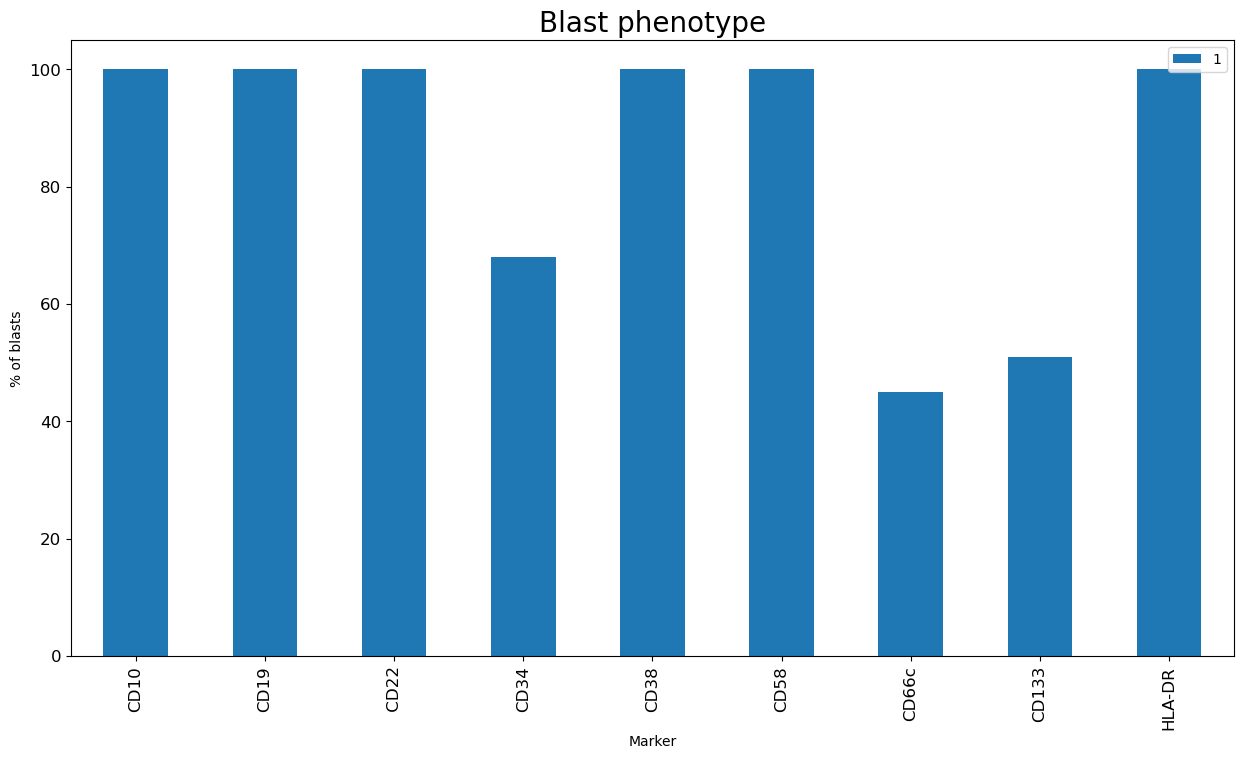

In [14]:
df=egflow * 100 #multiplied by 100 to get percentages

df1=df.T

df1.plot.bar(xlabel="Marker", ylabel="% of blasts",
            figsize= (15,8),
           fontsize="large") ;

plt.title('Blast phenotype', fontsize=20) ;

In [15]:
egflow=egflow*100

In [16]:
flow_markers=egflow.columns
flow_markers

Index(['CD10', 'CD19', ' CD22', 'CD34', 'CD38', 'CD58', 'CD66c', 'CD133',
       'HLA-DR'],
      dtype='object')

In [17]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_clr.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD10 Yes
CD19 Yes
 CD22 No
CD34 Yes
CD38 Yes
CD58 Yes
CD66c No
CD133 No
HLA-DR No
['CD10', 'CD19', 'CD34', 'CD38', 'CD58']


In [18]:
prot_clr.shape

(1011, 33)

In [45]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

Silhuette score: 0.5438441629972685
Percentage of positive cells, based on GMM: 67.06231454005935


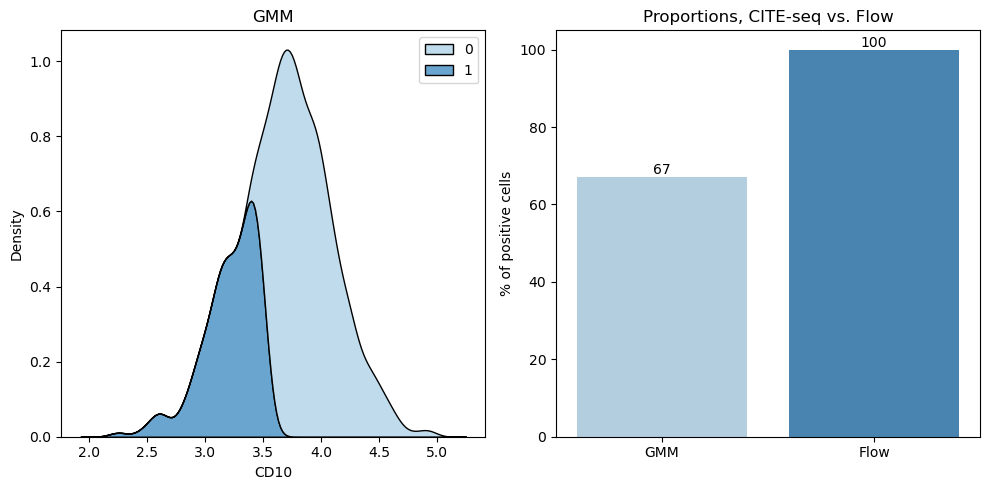

Silhuette score: 0.5611006299305206
Percentage of positive cells, based on GMM: 56.57764589515332


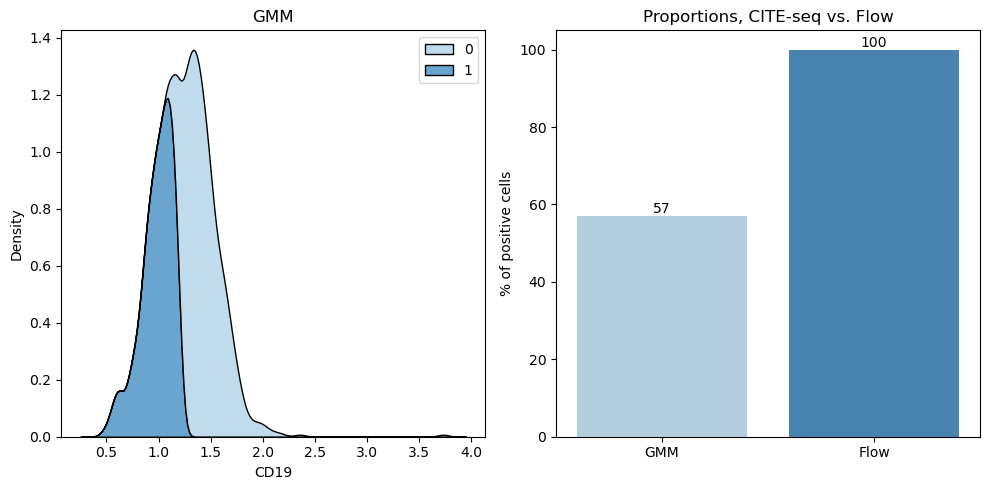

Silhuette score: 0.5735354650079836
Percentage of positive cells, based on GMM: 53.90702274975272


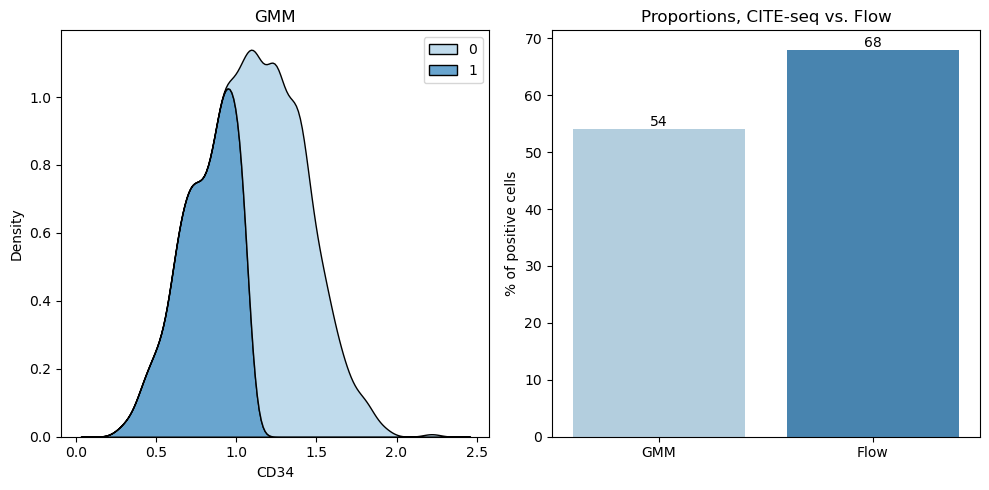

Silhuette score: 0.5747866562496052
Percentage of positive cells, based on GMM: 33.92680514342236


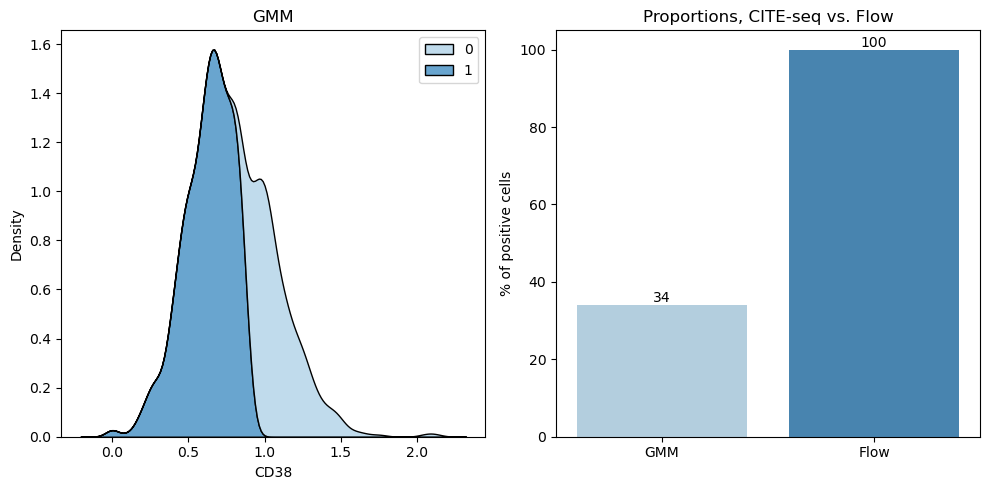

Silhuette score: 0.7928389743616737
Percentage of positive cells, based on GMM: 0.791295746785361


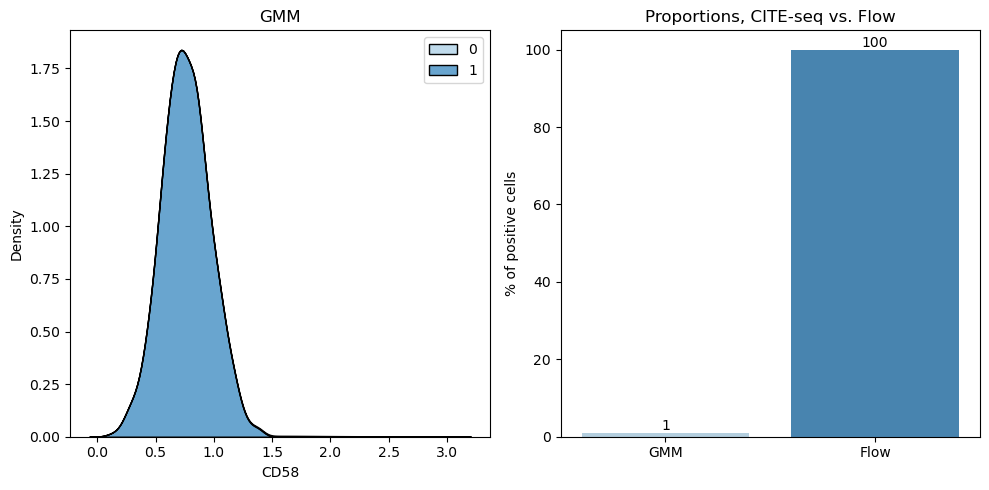

In [77]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_diag = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.5438441629972685
Percentage of positive cells, based on GMM: 67.06231454005935


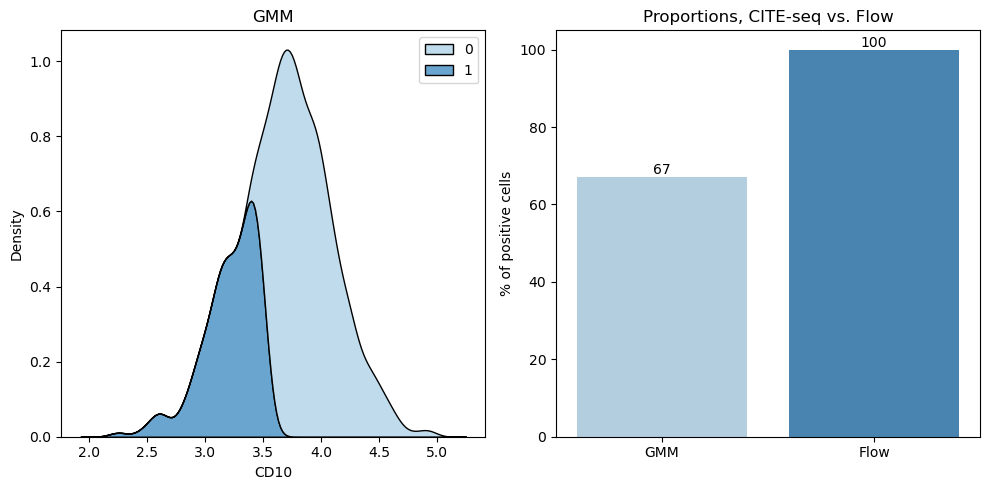

Silhuette score: 0.5611006299305206
Percentage of positive cells, based on GMM: 56.57764589515332


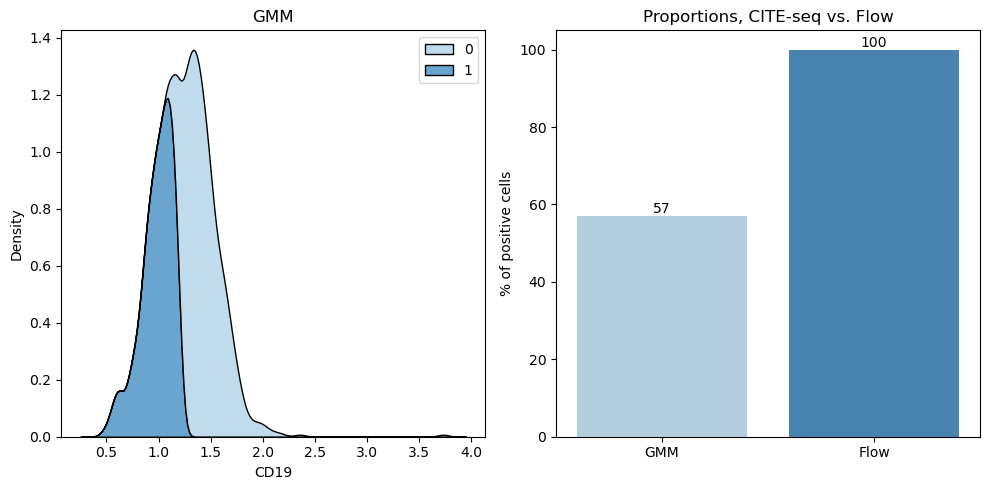

Silhuette score: 0.5735354650079836
Percentage of positive cells, based on GMM: 53.90702274975272


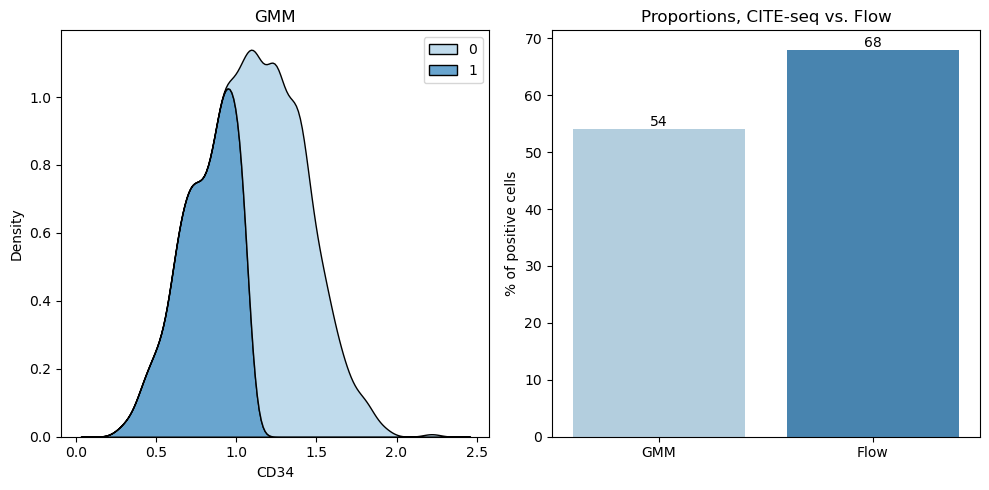

Silhuette score: 0.5747866562496052
Percentage of positive cells, based on GMM: 33.92680514342236


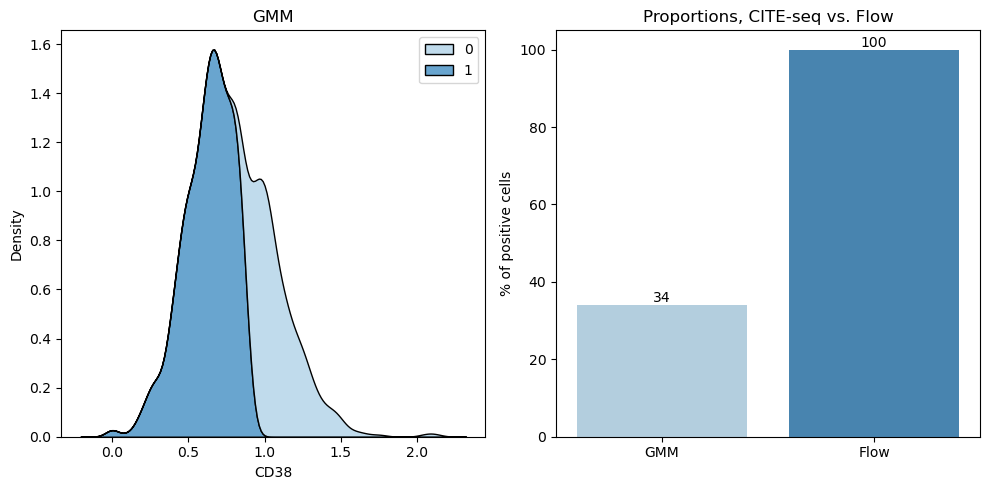

Silhuette score: 0.7928389743616737
Percentage of positive cells, based on GMM: 0.791295746785361


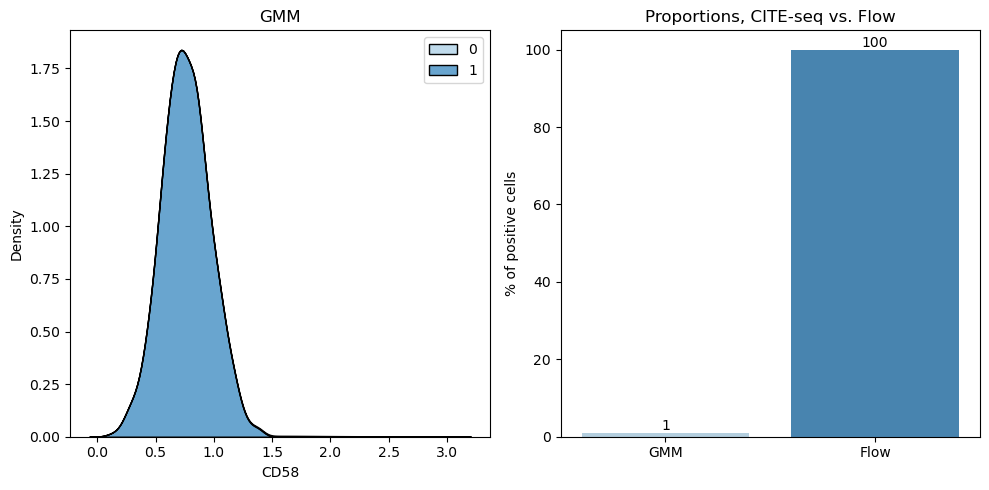

In [78]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_spher = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.542700742973934
Percentage of positive cells, based on GMM: 68.24925816023739


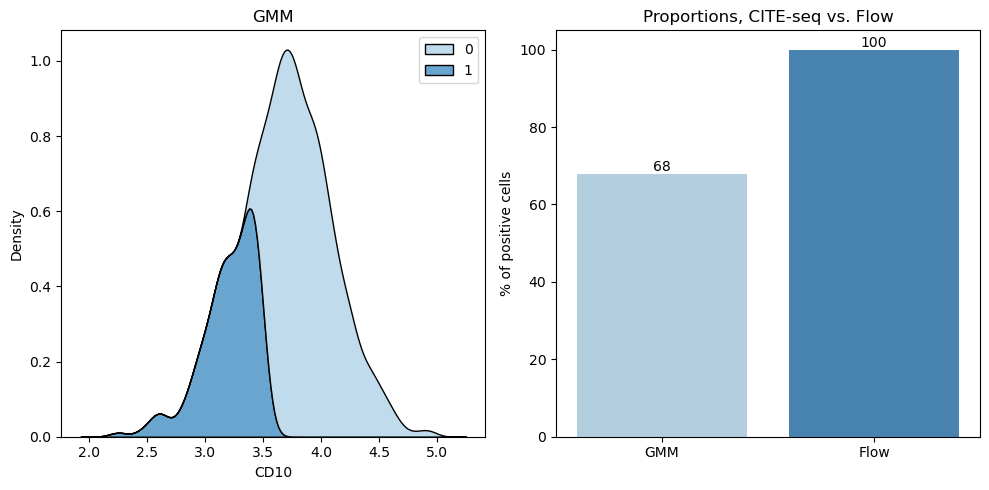

Silhuette score: 0.5604426576383049
Percentage of positive cells, based on GMM: 48.269040553907026


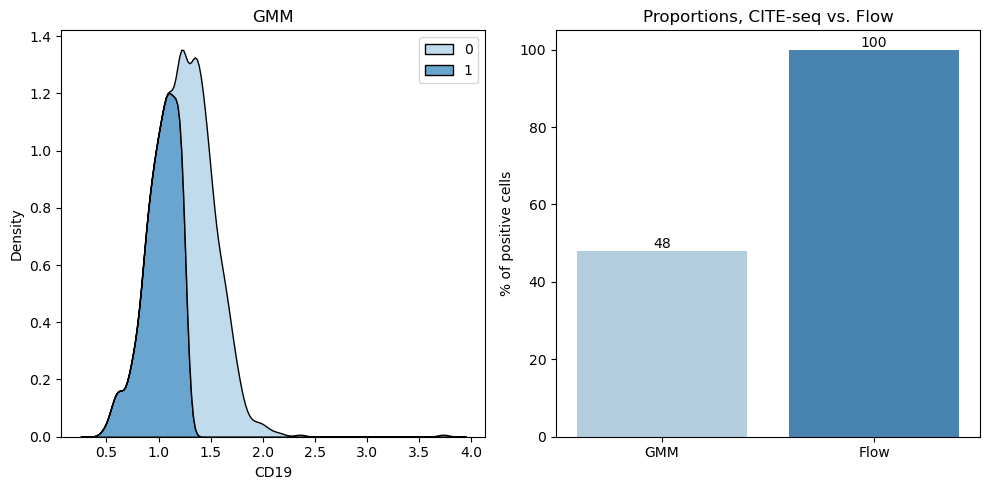

Silhuette score: 0.5735354650079836
Percentage of positive cells, based on GMM: 53.90702274975272


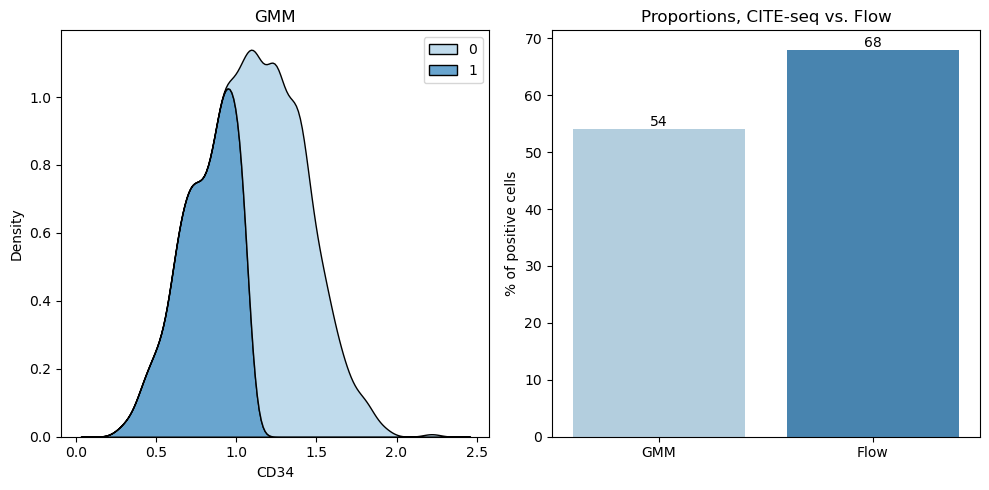

Silhuette score: 0.5555492178173981
Percentage of positive cells, based on GMM: 28.387734915924828


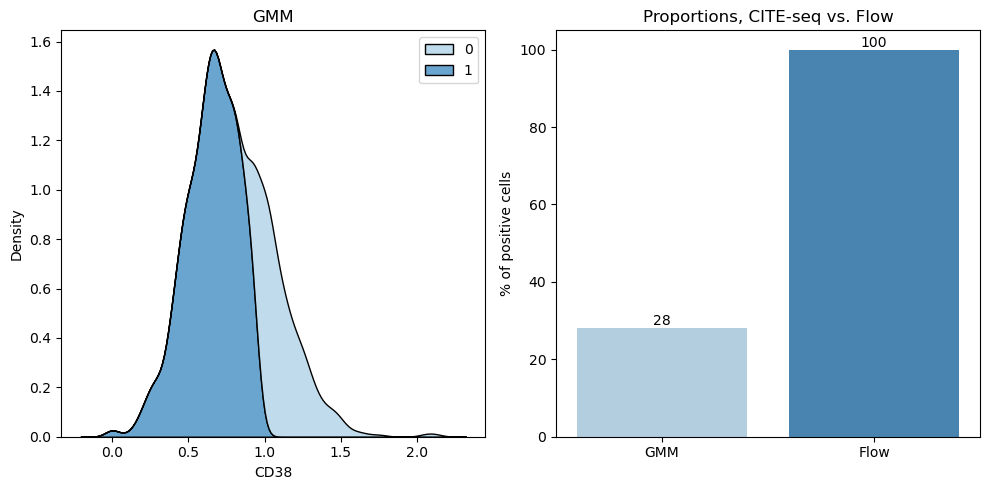

Silhuette score: 0.5478559086400548
Percentage of positive cells, based on GMM: 8.209693372898121


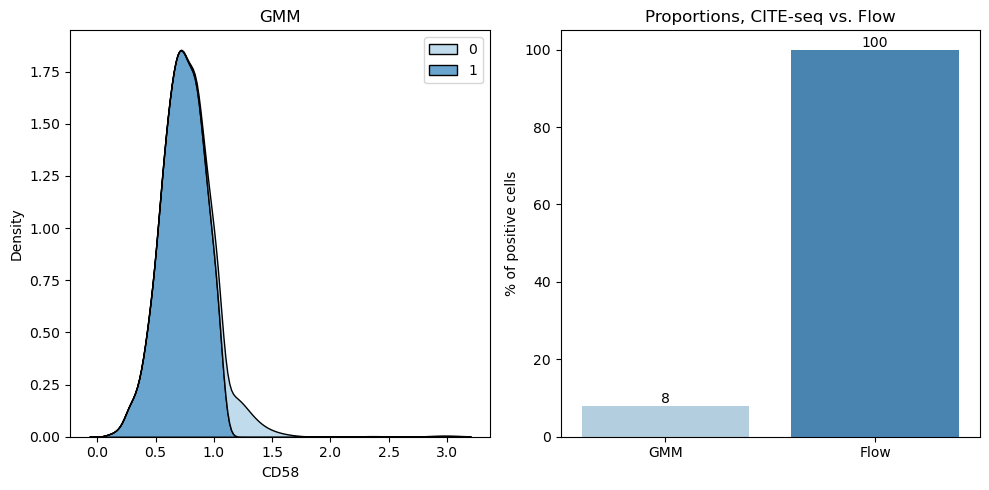

In [79]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.5438441629972685
Percentage of positive cells, based on GMM: 67.06231454005935


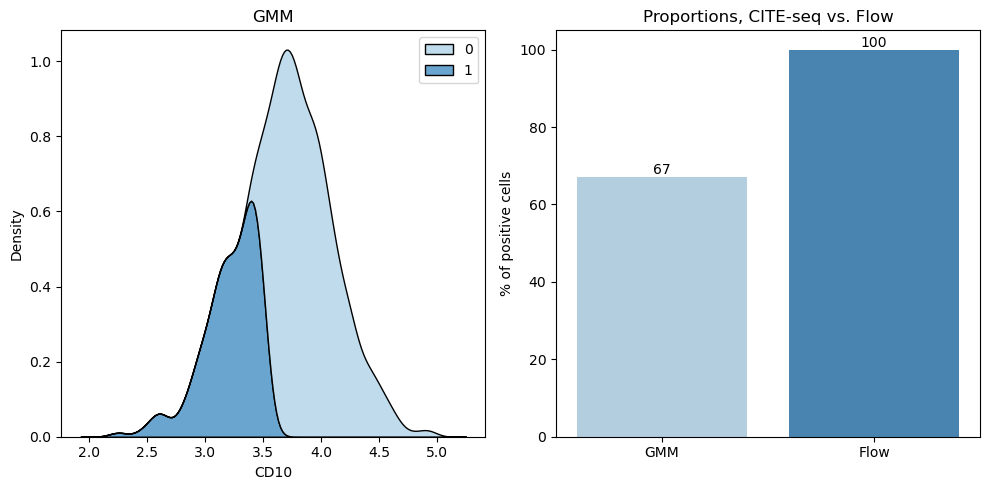

Silhuette score: 0.5611006299305206
Percentage of positive cells, based on GMM: 56.57764589515332


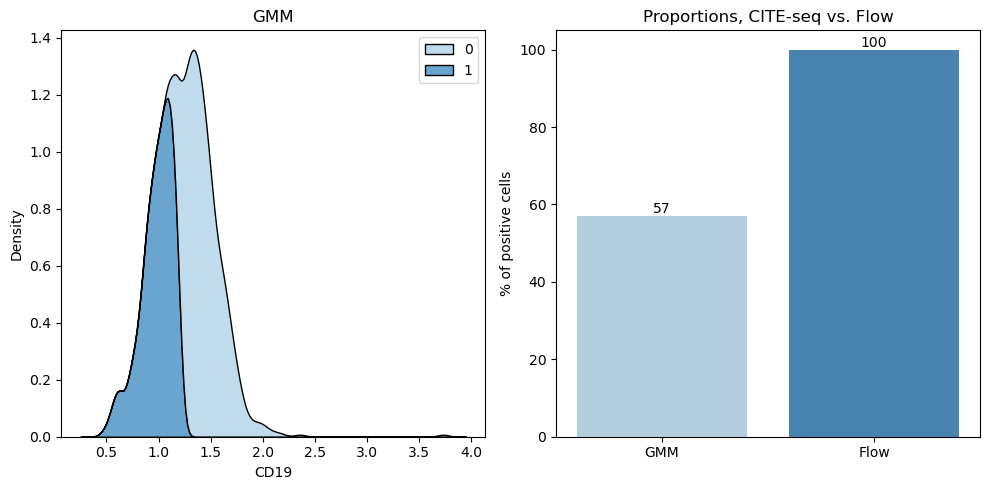

Silhuette score: 0.5735354650079836
Percentage of positive cells, based on GMM: 53.90702274975272


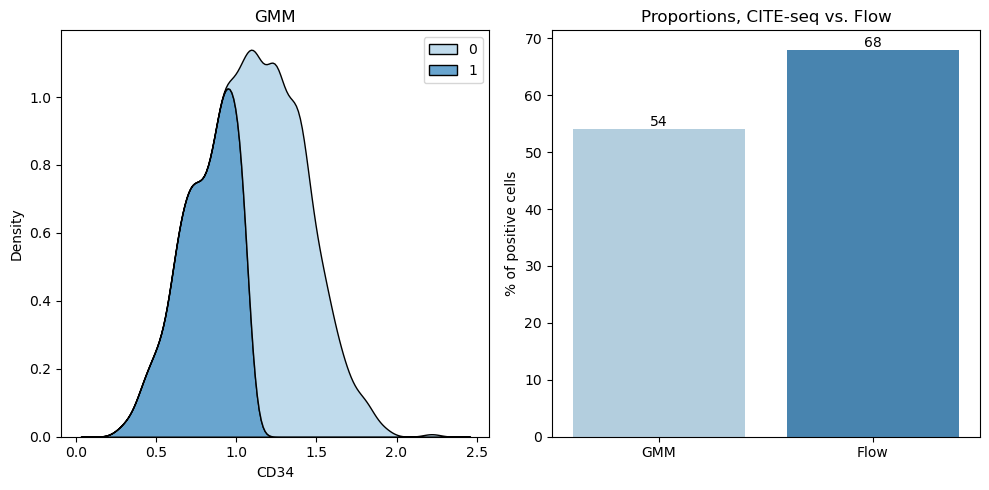

Silhuette score: 0.5747866562496052
Percentage of positive cells, based on GMM: 33.92680514342236


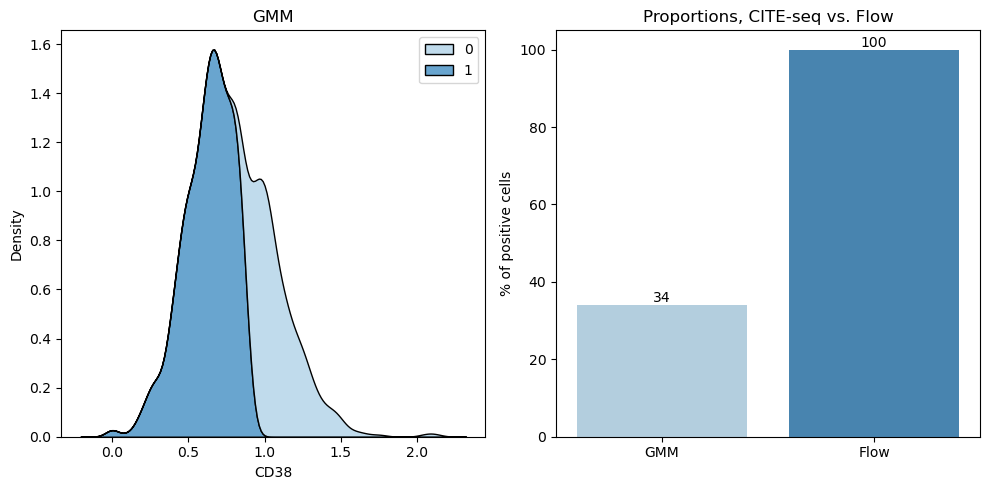

Silhuette score: 0.7928389743616737
Percentage of positive cells, based on GMM: 0.791295746785361


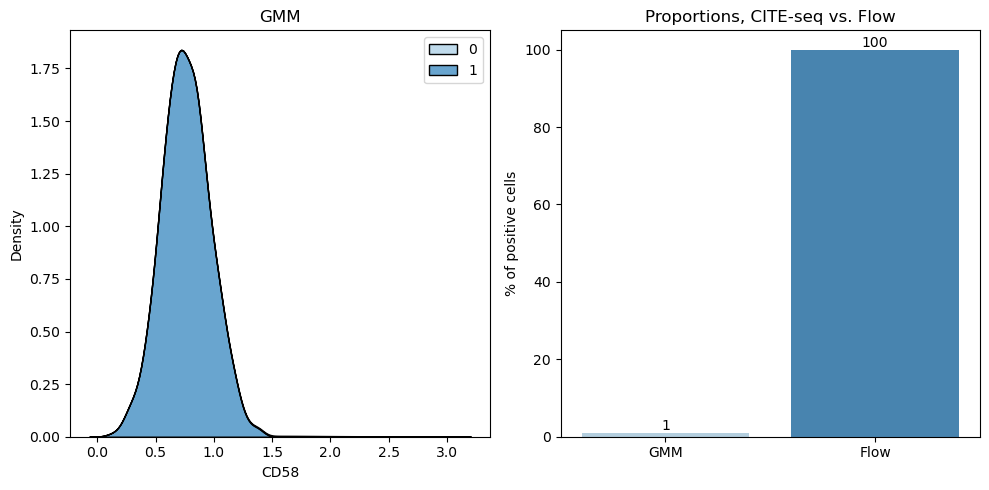

In [80]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_full = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

## DSB Normalized

In [21]:
prot_dsb

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACGGGTCTACTTAC-1-119,5.235474,6.765774,3.392691,0.808834,3.707282,2.972158,9.732417,12.509436,2.973591,-1.510255,...,0.891578,1.754948,2.642372,0.046999,5.641718,6.519819,1.705478,1.870252,2.644428,2.188816
AAAGATGAGGAGTAGA-1-119,1.098276,7.259014,1.393066,-0.646733,-1.678327,-0.076621,1.911605,4.575176,-0.277374,-1.510255,...,0.454759,-1.025544,-0.143150,-0.384310,7.088585,5.934313,0.767981,0.640264,0.505158,1.311661
AAAGCAACACAGACTT-1-119,1.726878,5.649791,2.285491,-0.962689,0.447542,-0.641244,3.161980,4.131022,-0.277374,-0.705994,...,0.454759,-0.674252,0.707019,-0.850160,6.819550,6.734242,0.222203,0.174821,-1.242754,1.311661
AAAGCAACAGGGTATG-1-119,2.258353,8.020568,-1.144322,-1.139418,0.796405,0.182565,2.358955,7.488725,0.597070,0.028237,...,-1.055551,1.059134,-0.560621,-0.384310,8.081855,4.882566,1.259085,1.870252,0.505158,1.311661
AAAGCAACATCACAAC-1-119,3.047345,9.353902,1.068179,-0.799064,0.077523,-0.076621,5.328226,4.131022,-0.277374,1.329014,...,0.454759,-0.344264,0.225084,-0.384310,2.581179,5.473848,1.914316,2.235003,1.982996,4.218381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCAGCCAACAG-1-119,0.810795,9.314544,-0.924099,0.096173,-0.316384,2.041421,8.672638,2.642952,-0.762677,-0.705994,...,-0.513795,-1.401081,-0.344923,0.824153,3.034776,6.681586,-0.391966,3.224028,-1.242754,5.373164
TTTGGTTAGAGCTGCA-1-119,1.609993,6.275143,0.298399,-0.244180,1.439466,-0.950627,2.774324,7.173814,0.994076,0.028237,...,1.688773,-0.344264,0.852458,-0.850160,3.463843,6.574390,1.487356,-0.865119,0.505158,-1.362772
TTTGTCAAGGTTCCTA-1-119,1.726878,7.955753,-0.524583,2.300853,1.439466,-0.076621,5.455982,5.400477,1.368383,1.329014,...,1.301905,-0.674252,0.225084,0.824153,4.980019,6.628307,2.492271,5.959399,-0.329018,3.618855
TTTGTCAGTATCACCA-1-119,3.556360,8.214930,3.756397,1.921420,0.077523,0.662341,5.580991,4.997655,0.174433,1.911199,...,0.454759,1.059134,-0.792311,0.046999,7.088585,7.546330,1.487356,3.224028,-0.329018,5.600803


In [22]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_dsb.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD10 Yes
CD19 Yes
 CD22 No
CD34 Yes
CD38 Yes
CD58 Yes
CD66c No
CD133 No
HLA-DR No
['CD10', 'CD19', 'CD34', 'CD38', 'CD58']


Silhuette score: 0.5221856
Percentage of positive cells: 36.39960435212661


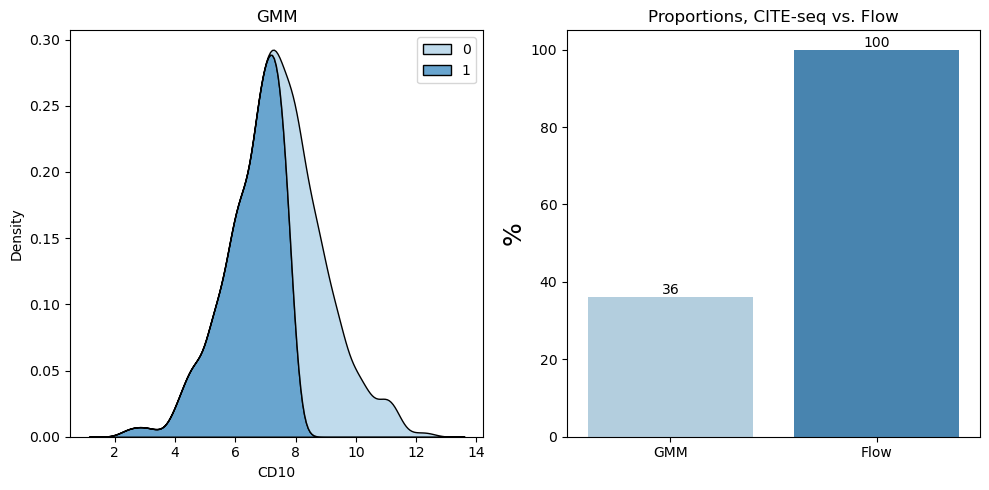

Silhuette score: 0.56900865
Percentage of positive cells: 50.939663699307616


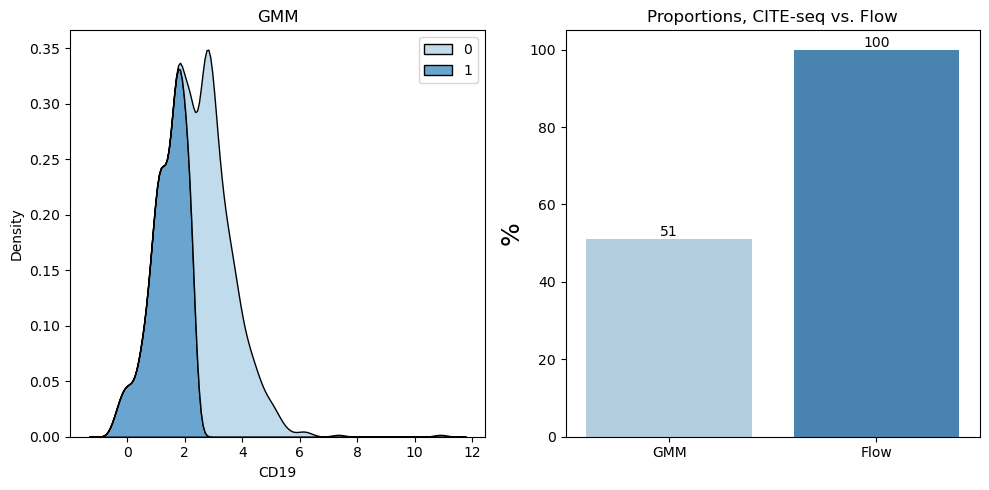

Silhuette score: 0.56555474
Percentage of positive cells: 46.78536102868447


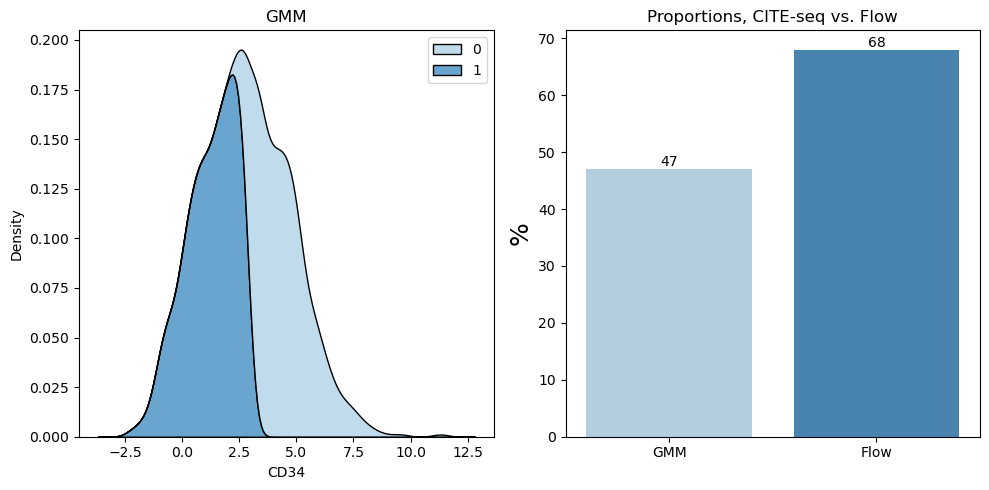

Silhuette score: 0.56936955
Percentage of positive cells: 31.355093966369928


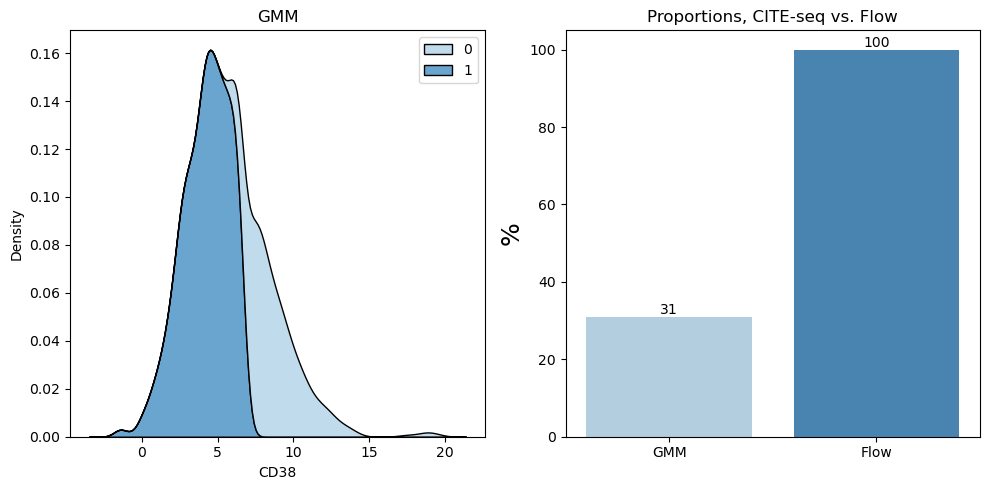

Silhuette score: 0.5243505
Percentage of positive cells: 19.287833827893174


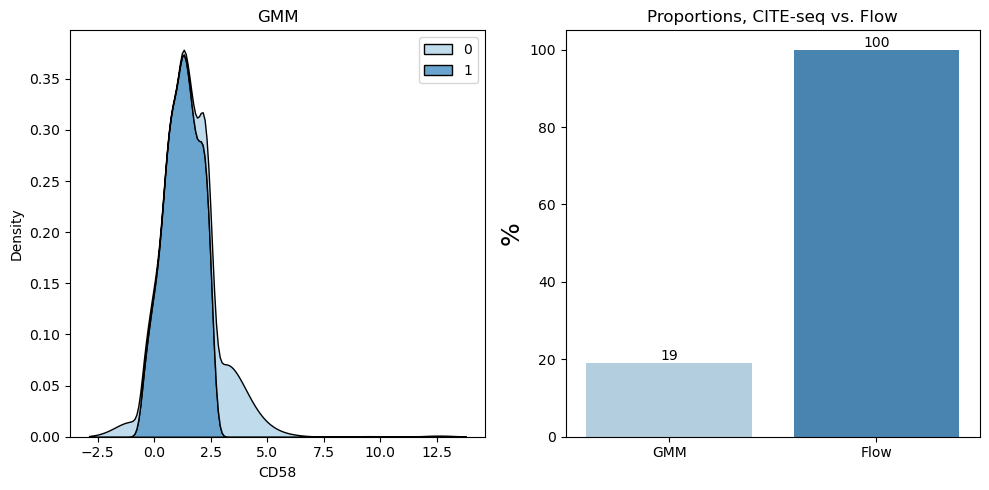

In [82]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_full = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.5221856
Percentage of positive cells: 36.39960435212661


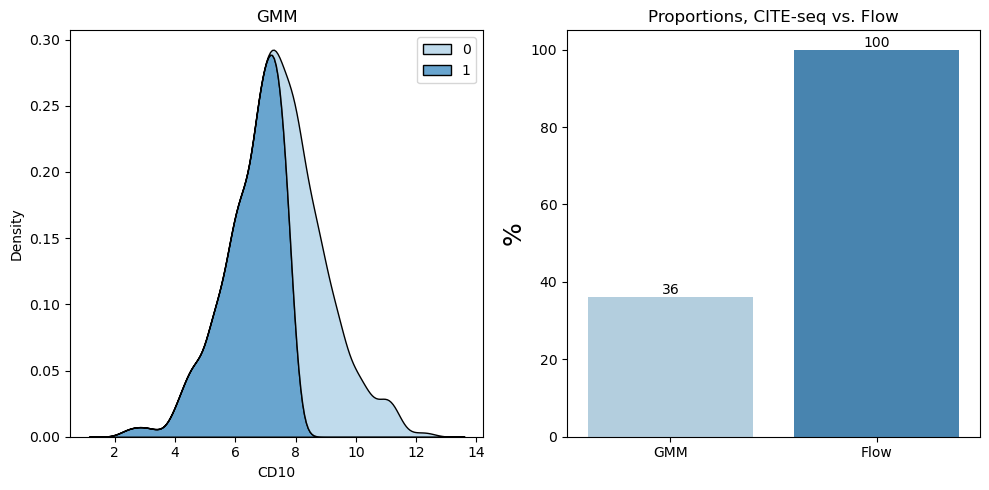

Silhuette score: 0.56900865
Percentage of positive cells: 50.939663699307616


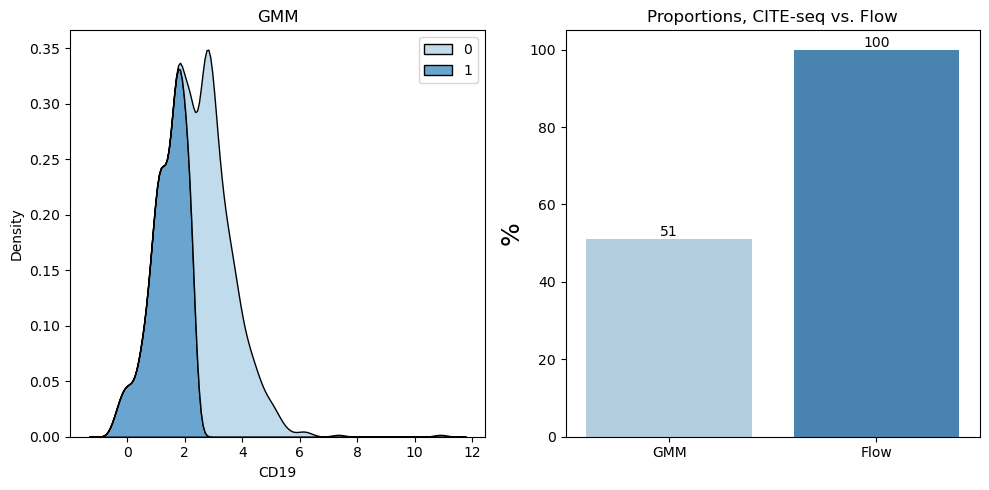

Silhuette score: 0.56555474
Percentage of positive cells: 46.78536102868447


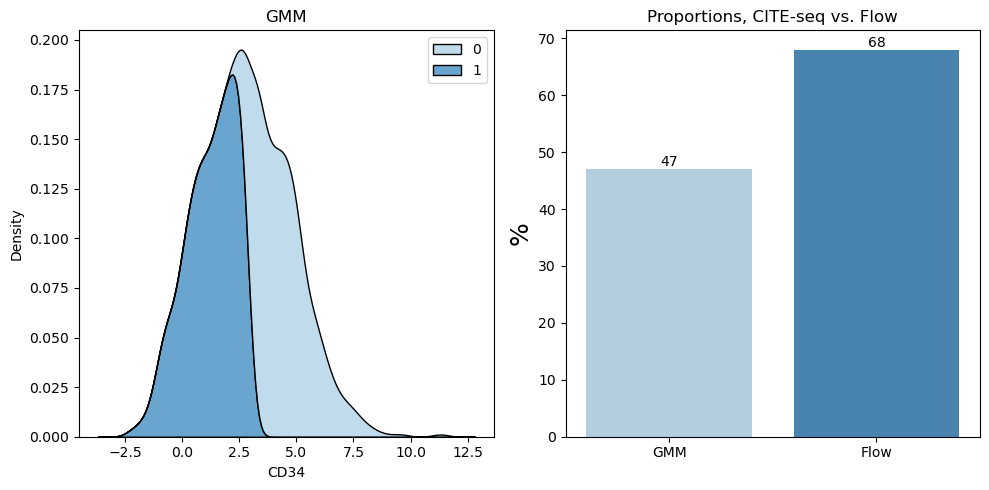

Silhuette score: 0.56936955
Percentage of positive cells: 31.355093966369928


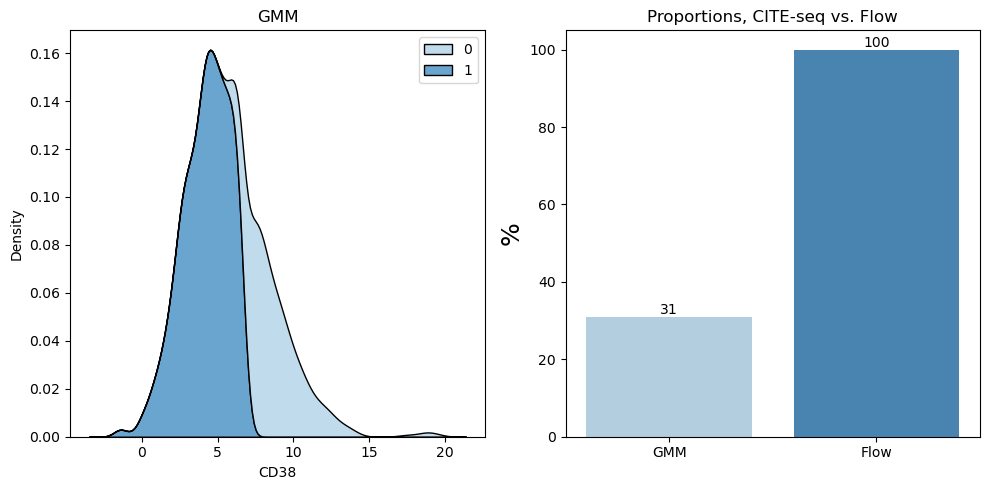

Silhuette score: 0.5243505
Percentage of positive cells: 19.287833827893174


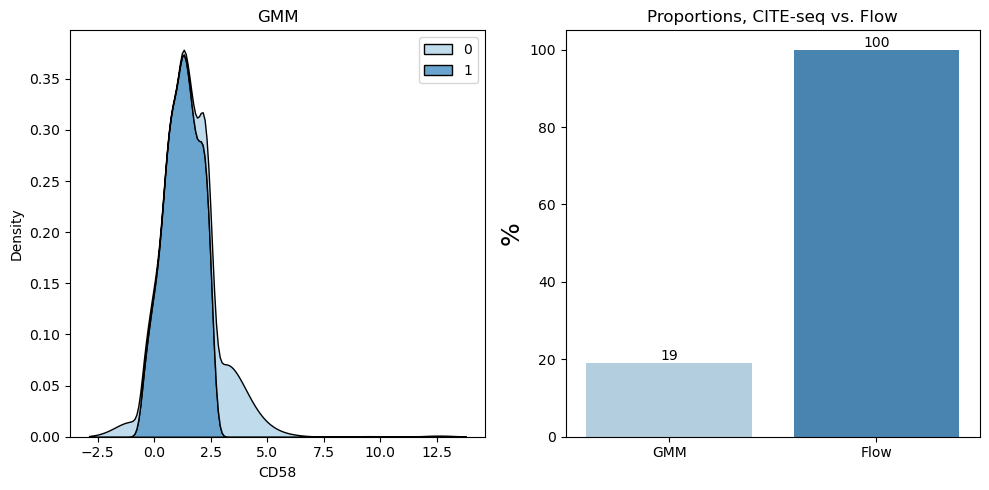

In [83]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_spher = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.52343524
Percentage of positive cells: 37.19090009891197


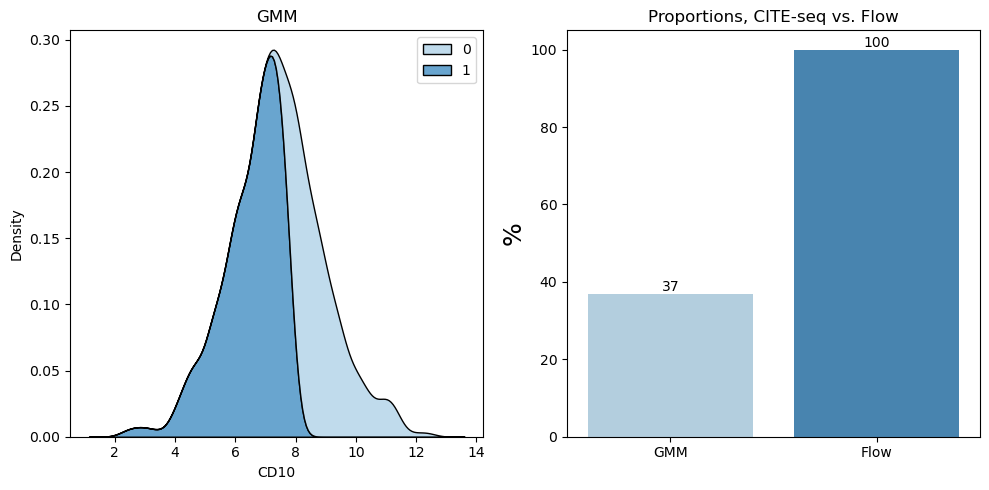

Silhuette score: 0.5544184
Percentage of positive cells: 43.02670623145401


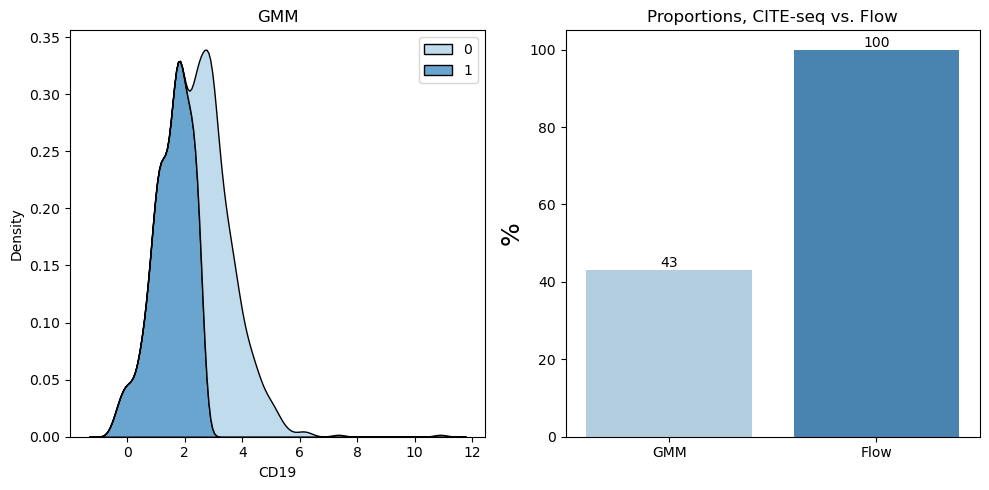

Silhuette score: 0.5632142
Percentage of positive cells: 44.11473788328388


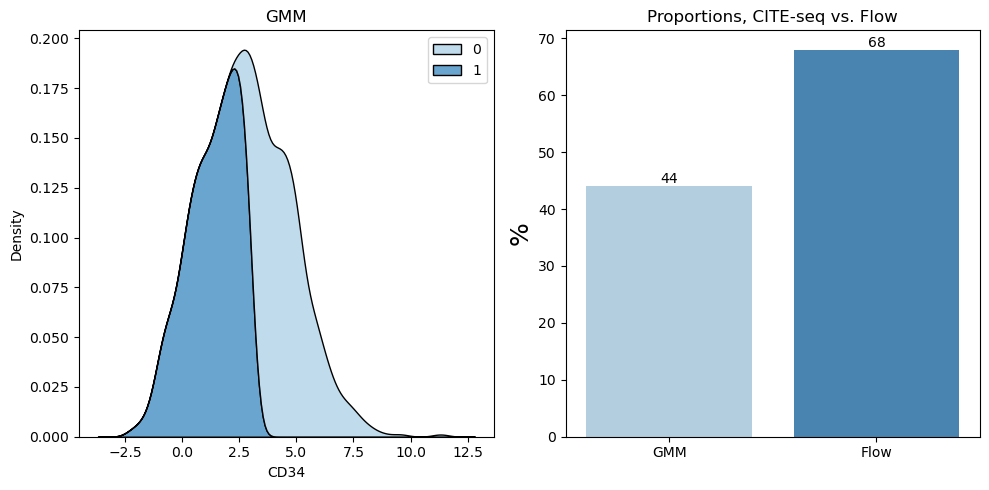

Silhuette score: 0.55260354
Percentage of positive cells: 18.397626112759642


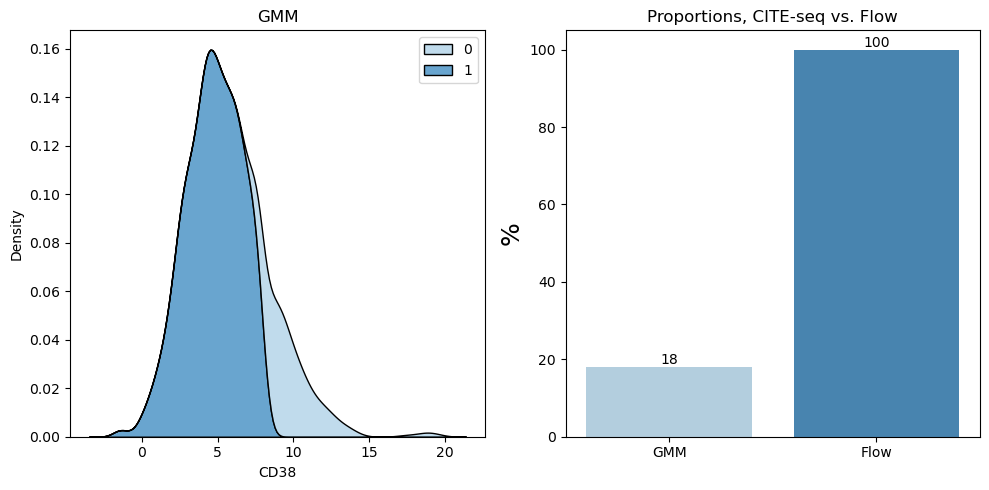

Silhuette score: 0.5622852
Percentage of positive cells: 11.572700296735905


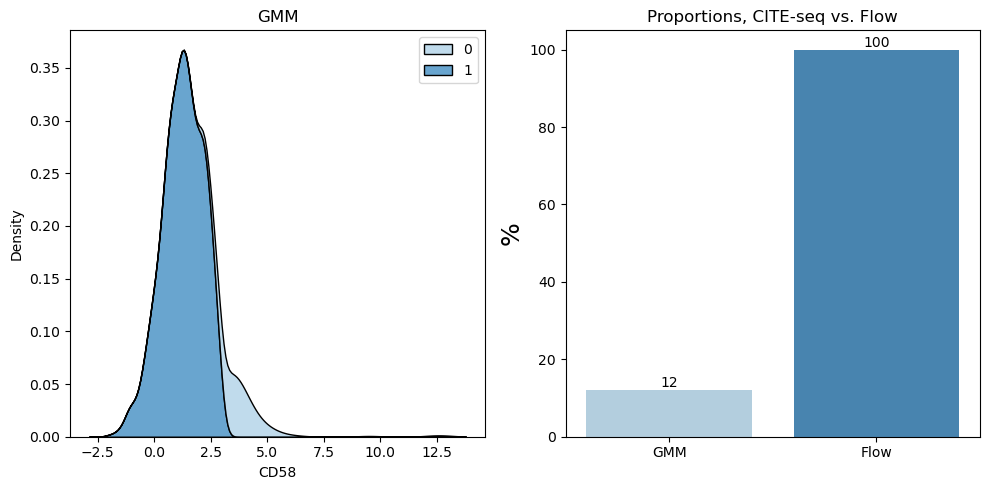

In [85]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.5221856
Percentage of positive cells: 36.39960435212661


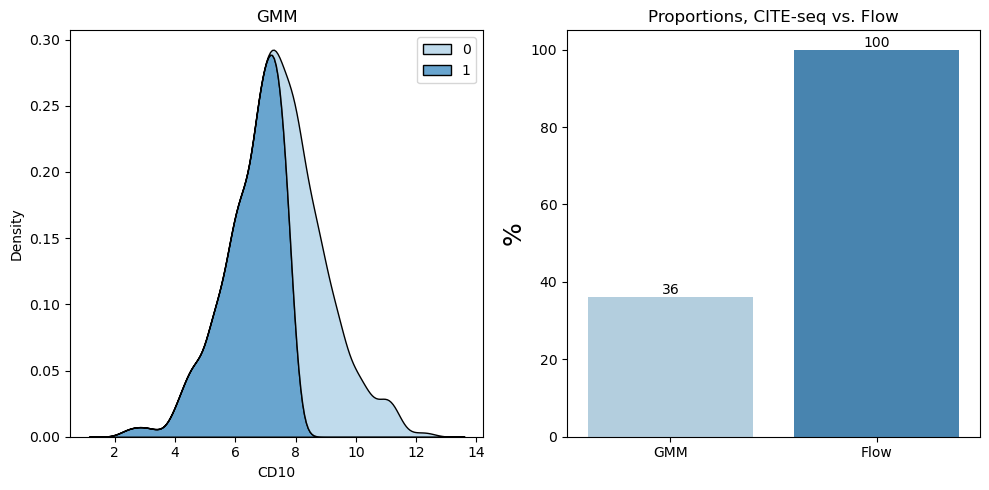

Silhuette score: 0.56900865
Percentage of positive cells: 50.939663699307616


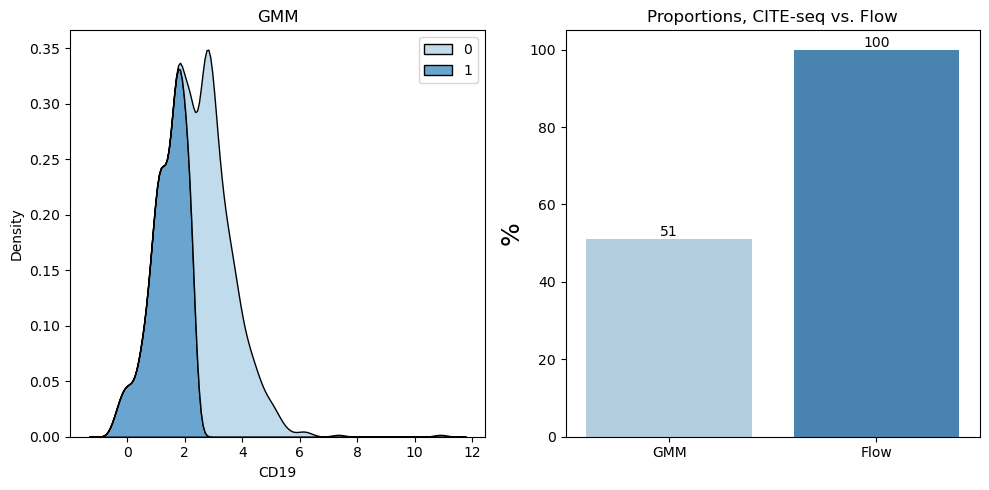

Silhuette score: 0.56555474
Percentage of positive cells: 46.78536102868447


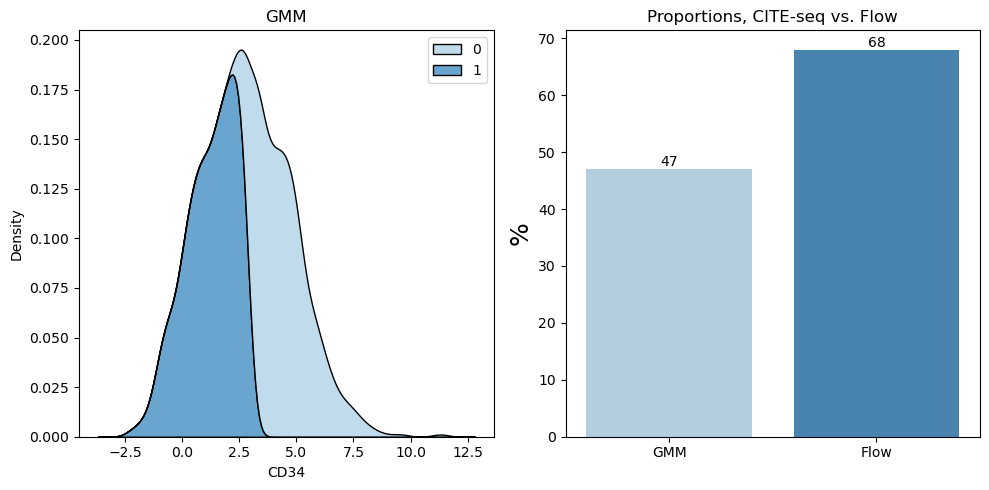

Silhuette score: 0.56936955
Percentage of positive cells: 31.355093966369928


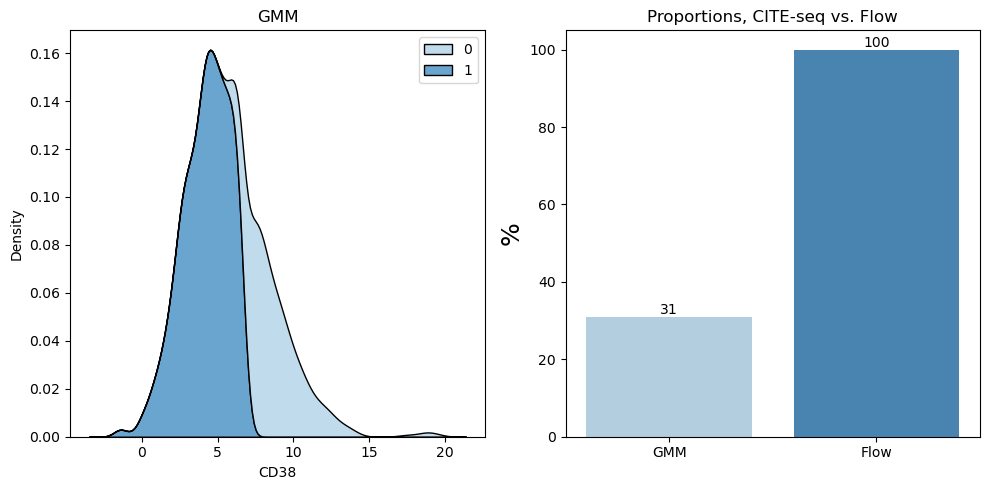

Silhuette score: 0.5243505
Percentage of positive cells: 19.287833827893174


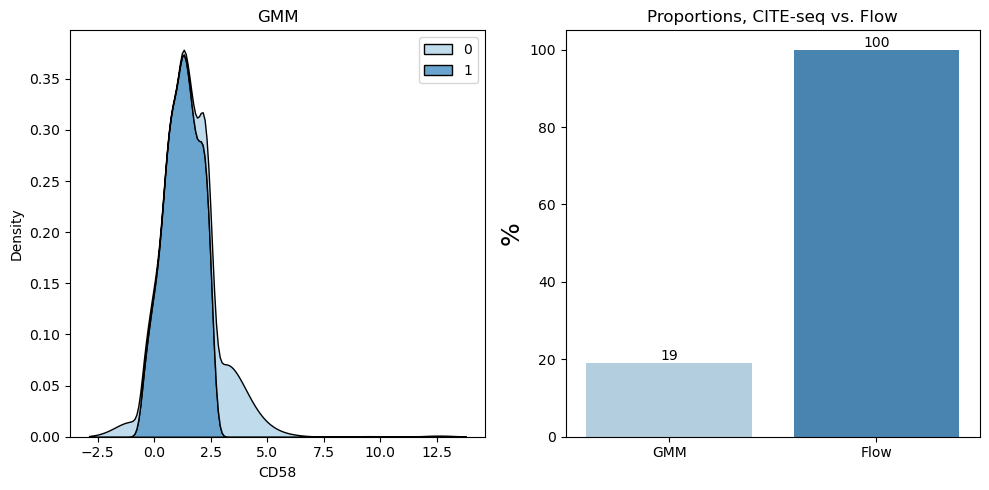

In [87]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_diag = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

In [123]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[0]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[0]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[0]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[0]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[0]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[0]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[0]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[0]]
      };

silhuette_df= pd.DataFrame(data=silhuettes)

silhuette_df.T

,0
silhuette_scores_dsb_diag,0.522186
silhuette_scores_dsb_spher,0.522186
silhuette_scores_dsb_tied,0.523435
silhuette_scores_dsb_full,0.522186
silhuette_scores_clr_diag,0.543844
silhuette_scores_clr_spher,0.543844
silhuette_scores_clr_tied,0.542701
silhuette_scores_clr_full,0.543844


In [124]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[1]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[1]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[1]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[1]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[1]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[1]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[1]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[1]]
      };

silhuette_df1= pd.DataFrame(data=silhuettes)

silhuette_df1.T

,0
silhuette_scores_dsb_diag,0.569009
silhuette_scores_dsb_spher,0.569009
silhuette_scores_dsb_tied,0.554418
silhuette_scores_dsb_full,0.569009
silhuette_scores_clr_diag,0.561101
silhuette_scores_clr_spher,0.561101
silhuette_scores_clr_tied,0.560443
silhuette_scores_clr_full,0.561101


In [125]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[2]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[2]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[2]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[2]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[2]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[2]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[2]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[2]]
      };

silhuette_df2= pd.DataFrame(data=silhuettes)

silhuette_df2.T

,0
silhuette_scores_dsb_diag,0.565555
silhuette_scores_dsb_spher,0.565555
silhuette_scores_dsb_tied,0.563214
silhuette_scores_dsb_full,0.565555
silhuette_scores_clr_diag,0.573535
silhuette_scores_clr_spher,0.573535
silhuette_scores_clr_tied,0.573535
silhuette_scores_clr_full,0.573535


In [126]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[3]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[3]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[3]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[3]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[3]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[3]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[3]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[3]]
      };

silhuette_df3= pd.DataFrame(data=silhuettes)

silhuette_df3.T

,0
silhuette_scores_dsb_diag,0.569370
silhuette_scores_dsb_spher,0.569370
silhuette_scores_dsb_tied,0.552604
silhuette_scores_dsb_full,0.569370
silhuette_scores_clr_diag,0.574787
silhuette_scores_clr_spher,0.574787
silhuette_scores_clr_tied,0.555549
silhuette_scores_clr_full,0.574787


In [127]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[4]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[4]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[4]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[4]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[4]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[4]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[4]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[4]]
      };

silhuette_df4= pd.DataFrame(data=silhuettes)

silhuette_df4.T

,0
silhuette_scores_dsb_diag,0.524351
silhuette_scores_dsb_spher,0.524351
silhuette_scores_dsb_tied,0.562285
silhuette_scores_dsb_full,0.524351
silhuette_scores_clr_diag,0.792839
silhuette_scores_clr_spher,0.792839
silhuette_scores_clr_tied,0.547856
silhuette_scores_clr_full,0.792839


In [128]:
column_names


['CD10', 'CD19', 'CD34', 'CD38', 'CD58']

In [129]:
the_df.columns

Index(['silhuette_scores_dsb_diag', 'silhuette_scores_dsb_spher',
       'silhuette_scores_dsb_tied', 'silhuette_scores_dsb_full',
       'silhuette_scores_clr_diag', 'silhuette_scores_clr_spher',
       'silhuette_scores_clr_tied', 'silhuette_scores_clr_full', 'Protein'],
      dtype='object')

In [130]:
the_df= pd.concat([silhuette_df,silhuette_df1,silhuette_df2,silhuette_df3,silhuette_df4], axis=0)


In [132]:
the_df = the_df.T

the_df

,0,0,0,0,0
silhuette_scores_dsb_diag,0.522186,0.569009,0.565555,0.569370,0.524351
silhuette_scores_dsb_spher,0.522186,0.569009,0.565555,0.569370,0.524351
silhuette_scores_dsb_tied,0.523435,0.554418,0.563214,0.552604,0.562285
silhuette_scores_dsb_full,0.522186,0.569009,0.565555,0.569370,0.524351
silhuette_scores_clr_diag,0.543844,0.561101,0.573535,0.574787,0.792839
silhuette_scores_clr_spher,0.543844,0.561101,0.573535,0.574787,0.792839
silhuette_scores_clr_tied,0.542701,0.560443,0.573535,0.555549,0.547856
silhuette_scores_clr_full,0.543844,0.561101,0.573535,0.574787,0.792839


In [133]:
the_df.columns = column_names

In [135]:
the_df= the_df.T


In [136]:
the_df

,CD10,CD19,CD34,CD38,CD58
silhuette_scores_dsb_diag,0.522186,0.569009,0.565555,0.569370,0.524351
silhuette_scores_dsb_spher,0.522186,0.569009,0.565555,0.569370,0.524351
silhuette_scores_dsb_tied,0.523435,0.554418,0.563214,0.552604,0.562285
silhuette_scores_dsb_full,0.522186,0.569009,0.565555,0.569370,0.524351
silhuette_scores_clr_diag,0.543844,0.561101,0.573535,0.574787,0.792839
silhuette_scores_clr_spher,0.543844,0.561101,0.573535,0.574787,0.792839
silhuette_scores_clr_tied,0.542701,0.560443,0.573535,0.555549,0.547856
silhuette_scores_clr_full,0.543844,0.561101,0.573535,0.574787,0.792839


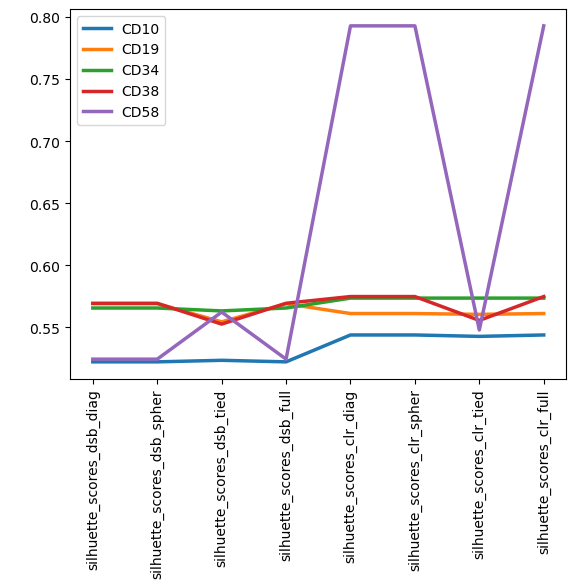

In [152]:
a = sns.lineplot(data=the_df["CD10"], palette=['red'], linewidth=2.5, label='CD10')
a = sns.lineplot(data=the_df["CD19"], palette=['green'], linewidth=2.5, label='CD19')
a = sns.lineplot(data=the_df["CD34"],palette=['black'],linewidth=2.5, label='CD34')
a = sns.lineplot(data=the_df["CD38"],palette=['blue'],linewidth=2.5, label='CD38')
a = sns.lineplot(data=the_df["CD58"],palette=['violet'],linewidth=2.5, label='CD58')

a.set_xticklabels(a.get_xticklabels(),rotation=90) ;
plt.ylabel(" ");

